<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Странно - потому что обычно из текста делают какой-то вектор (например тфидф), а идти по нему свёрткой быссмысленно, т.к. никаких паттернов для рядом стоящих координат быть не может (координаты тф-ов могут быть какими угодно). 
Как вариант - возьмём словарик, пронумеруем - это пространство цветов (слово - определенный цвет пикселя). Есть строчка последовательно идущих слов (пикселей), применим одномерную свертку (или много) - получим детектинг определенных паттерном (на самом деле он просто будет искать 1..n-граммы, где n-размерность ядра свертки). можно конечно записать эмбединги слов в столбцы, а столбцы друг за другом как они идут в тексте - получится какая-то матрица, и дальше можно смотреть на неё как на картинку. авось и выйдет что-то интересное. но интуитивно не очень понимаю, зачем так делать - ведь в картинке соседние пиксели как по горизонтали, так и по вертикали связаны, а в такой матрице связанными могут быть только горизонтальные подстроки (значения в одних подпространствах ембединга слов) - что за связь может быть у вертикальных колонок, причем с одним и тем же ядром и в разных местах?  - может быть, стоит тут уже применить одномерную свертку и тогда всё точно ок.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

Лучше тем, что градиент не затухает - мы контролируем его (производную памяти по предыдущей) за счёт forget-вектора и можем сделать так, чтобы произведение было не совсем маленьким. Таким образом, память получается сильно больше (помнит больше состояний назад)

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

# $ C_t = f_t \cdot C_{t-1} + i_t \cdot \hat{C_t}$

# $\hat{C_t} = tanh(W_c \cdot [h_{t-1}, x_t] + b_C)$ - не зависит от $C_t$, значит производная = 0

# $\frac{d C_{t+1}}{d C_{t}} = \frac{d (f_t \cdot C_{t-1})}{d C_{t-1}} = f_t$

# k < n

# $\frac{d C_{n}}{d C_{k}} = \frac{d C_{n}}{d C_{n-1}}\frac{d C_{n-1}}{d C_{n-2}}...\frac{d C_{k-1}}{d C_{k}} = f_{n-1} \cdot f_{n-2} \cdot ... \cdot f_{k}$ 

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

1) дорого/долго/вычислительно_трудно (если входные последовательности очень большие) проталкивать ошибку так далеко

2) градиент для больших последовательностей затухает



**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Эмбединг чего угодно в вектор сверточной сетью, чтобы затем скормить этот вектор рекуррентной сети на старт (или постоянно иметь этот веткор в виду как дополнительное скрытое состояние)
Примеры - подписи к картинкам, рекомендашки на основе какой-то фотографии пользователя + его истории, диалоговый бот у которого есть фотка юзера

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Как я понял, размер эмбединг слоя == размерность вектора, полученного из изображения и скармливаемого дальше

Опасно взять мало, потому что можно потерять информацию о картинке

Опасно взять много, потому что дальнейшая сеть будет долго работать (размерность необязательно должна совпадать с размерностью элемента последовательности из входа следующей сети (ванхот енкодинг чаров например), она же умножается на матрицу - вот эта матрица как раз и должна быть адекватного не огромного размера, иначе её веса не натрейнятся)

Если же имеется в виду ембединг слов/символов, то опасно делать one-hot при большом алфавите/словаре (получится слишком длинный вектор). Может быть, pca над ванхотом нормально справится

Оптимально - 1024 (потому что гладиолус)

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
import sys
import os
import time
import string
import random
import pickle
import cPickle

import numpy as np
import theano
import theano.tensor as T
import lasagne

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:08:00.0)


In [2]:
# !wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
# !tar -xvzf data.tar.gz

### Data preprocessing

In [3]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.86 s, sys: 348 ms, total: 3.21 s
Wall time: 3.21 s


In [4]:
print("each image code is a 1000-unit vector:", img_codes.shape)
print(img_codes[0,:10])
print("for each image there are 5-7 descriptions, e.g.:\n")
print('\n'.join(captions[0]))

('each image code is a 1000-unit vector:', (123287, 1000))
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]
for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [5]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [6]:
captions[0]

[['#START#',
  u'a',
  u'man',
  u'with',
  u'a',
  u'red',
  u'helmet',
  u'on',
  u'a',
  u'small',
  u'moped',
  u'on',
  u'a',
  u'dirt',
  u'road',
  '#END#'],
 ['#START#',
  u'man',
  u'riding',
  u'a',
  u'motor',
  u'bike',
  u'on',
  u'a',
  u'dirt',
  u'road',
  u'on',
  u'the',
  u'countryside',
  '#END#'],
 ['#START#',
  u'a',
  u'man',
  u'riding',
  u'on',
  u'the',
  u'back',
  u'of',
  u'a',
  u'motorcycle',
  '#END#'],
 ['#START#',
  u'a',
  u'dirt',
  u'path',
  u'with',
  u'a',
  u'young',
  u'person',
  u'on',
  u'a',
  u'motor',
  u'bike',
  u'rests',
  u'to',
  u'the',
  u'foreground',
  u'of',
  u'a',
  u'verdant',
  u'area',
  u'with',
  u'a',
  u'bridge',
  u'and',
  u'a',
  u'background',
  u'of',
  u'cloud',
  u'wreathed',
  u'mountains',
  '#END#'],
 ['#START#',
  u'a',
  u'man',
  u'in',
  u'a',
  u'red',
  u'shirt',
  u'and',
  u'a',
  u'red',
  u'hat',
  u'is',
  u'on',
  u'a',
  u'motorcycle',
  u'on',
  u'a',
  u'hill',
  u'side',
  '#END#']]

In [7]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
from collections import Counter

all_words = []
for img_captions in captions:
    for caption in img_captions:
        all_words += caption
    
word_counts = Counter(all_words)

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [9]:
#try it out on several descriptions of a random image
[list(map(lambda i:vocab[i], row))for row in as_matrix(captions[1337][:2])]

[['#START#',
  u'an',
  u'old',
  u'black',
  u'and',
  u'white',
  u'photo',
  u'of',
  u'two',
  u'men',
  u'in',
  u'suits',
  '#END#'],
 ['#START#',
  u'two',
  u'men',
  u'are',
  u'pictured',
  u'wearing',
  u'suits',
  u'in',
  u'this',
  u'historical',
  u'photo',
  '#END#',
  u'rotting']]

In [10]:
as_matrix(captions[1337])[:2]

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1]], dtype=int32)

### Mah Neural Network

In [11]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 512 #pls change me if u want
LSTM_UNITS = 256 #pls change me if u want

In [12]:
VOCABULARY_SIZE = len(vocab)

In [13]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [14]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [15]:
# #network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

# #embeddings for words 
# ############# TO CODE IT BY YOURSELF ##################

l_word_embeddings = EmbeddingLayer(l_words, 
                                   input_size=VOCABULARY_SIZE, 
                                   output_size=EMBED_SIZE)

In [16]:
# # input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

# ############# TO CODE IT BY YOURSELF ##################
# #convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
# #it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features, p=0.25)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
# # <Apply Dense to acive LSTM_UNITS size of representation>
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [17]:
# l_image_features_small = lasagne.layers.ReshapeLayer(l_image_features_small, ([0], 1, [1]))
# l_rnn_input = lasagne.layers.ConcatLayer([l_image_features_small, l_word_embeddings])

decoder  = LSTMLayer(l_word_embeddings,
                     num_units=LSTM_UNITS,
                     cell_init=l_image_features_small,
                     mask_input=l_mask,
                     grad_clipping=128.0)

In [18]:
from broadcast import BroadcastLayer, UnbroadcastLayer

In [19]:
# Decoding of rnn hiden states


#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 256)
output shape =  (None, None, 10373)


In [20]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############ TO CODE IT BY YOURSELF ##################
# loss = T.mean(loss[output_mask.nonzero()])
# <mean over non-PAD tokens>
loss = (loss * output_mask).sum() / output_mask.sum()

In [21]:
# #trainable NN weights
# ############# TO CODE IT BY YOURSELF ##################
# weights = lasagne.layers.get_all_params(predicted_probabilities, trainable=True)



weights = get_all_params(predicted_probabilities)

MAX_GRAD_NORM = 15

all_grads = T.grad(loss, weights)
all_grads = [T.clip(g, -5, 5) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(
    all_grads, MAX_GRAD_NORM, return_norm=True)

updates = lasagne.updates.adam(all_grads, weights, learning_rate=0.01)


# updates = lasagne.updates.adam(loss, weights)

In [22]:
# #compile a function that takes input sentence and image mask, outputs loss and updates weights
# #please not that your functions must accept image features as FIRST param and sentences as second one
# ############# TO CODE IT BY YOURSELF ##################

# # # Input Variable
# # sentences = T.imatrix()# [batch_size x time] of word ids
# # image_vectors = T.matrix() # [batch size x unit] of CNN image features
# # sentence_mask = T.neq(sentences, PAD_ix)

# train_step = theano.function([image_vectors, sentences], loss, updates=updates,
#                              allow_input_downcast=True, on_unused_input='ignore')

# val_step = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)
# probs = theano.function([image_vectors], network_output, allow_input_downcast=True)

# # train_step = <>
# # val_step   = <>

train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [23]:
captions = np.array(captions)

In [24]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [25]:
generate_batch(img_codes,captions, 3)

(array([[-1.62868655, -1.27043545,  0.23063418, ...,  0.26702249,
         -1.67818153, -2.01130438],
        [-1.39071679, -2.47772384, -1.43128181, ...,  1.0083642 ,
          1.40048349,  2.31063557],
        [-0.3229714 , -0.4512884 , -0.78811455, ..., -0.64863795,
          2.16212654,  6.38070965]], dtype=float32),
 array([[8481, 6766, 1438, 7646, 8587, 8717, 4556, 1987, 3017, 8717, 5989,
         8134],
        [8481, 8717, 8897, 1558,  781, 8717, 2312, 7645, 8528, 8717, 1779,
         8134],
        [8481, 3323, 2200, 3974, 4557,  781, 2852, 1759, 3792, 8134,   -1,
           -1]], dtype=int32))

In [26]:
x, y = generate_batch(img_codes,captions, 3)
x.shape, y.shape

((3, 1000), (3, 13))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [26]:
batch_size = 50 #adjust me
n_epochs   = 64 #adjust me
n_batches_per_epoch = 200 #adjust me
n_validation_batches = 10 #how many batches are used for validation after each epoch

In [27]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

100%|██████████| 200/200 [00:11<00:00, 18.03it/s]


Epoch: 0, train loss: 4.21790900826, val loss: 3.5346606493

Epoch: 1, train loss: 3.50302247643, val loss: 3.3543651104


100%|██████████| 200/200 [00:11<00:00, 17.96it/s]



Epoch: 2, train loss: 3.33552623272, val loss: 3.20865321159


100%|██████████| 200/200 [00:10<00:00, 18.21it/s]



Epoch: 3, train loss: 3.27177636981, val loss: 3.36810562611


100%|██████████| 200/200 [00:11<00:00, 18.08it/s]



Epoch: 4, train loss: 3.25229722738, val loss: 3.15109229088


100%|██████████| 200/200 [00:11<00:00, 17.83it/s]



Epoch: 5, train loss: 3.17474567771, val loss: 3.17664248943


100%|██████████| 200/200 [00:10<00:00, 18.48it/s]



Epoch: 6, train loss: 3.16941779137, val loss: 3.17769210339


100%|██████████| 200/200 [00:10<00:00, 18.58it/s]



Epoch: 7, train loss: 3.13597996354, val loss: 3.16977448463


100%|██████████| 200/200 [00:11<00:00, 18.11it/s]



Epoch: 8, train loss: 3.1238529551, val loss: 3.12421085835


100%|██████████| 200/200 [00:10<00:00, 17.51it/s]



Epoch: 9, train loss: 3.11764613032, val loss: 3.0061930418


100%|██████████| 200/200 [00:10<00:00, 18.47it/s]



Epoch: 10, train loss: 3.1013048625, val loss: 3.07210726738


100%|██████████| 200/200 [00:11<00:00, 16.62it/s]



Epoch: 11, train loss: 3.0976581645, val loss: 3.10411481857


100%|██████████| 200/200 [00:10<00:00, 18.33it/s]



Epoch: 12, train loss: 3.10271294832, val loss: 3.09151101112


100%|██████████| 200/200 [00:11<00:00, 16.15it/s]



Epoch: 13, train loss: 3.08342060566, val loss: 3.13817265034


100%|██████████| 200/200 [00:10<00:00, 18.30it/s]



Epoch: 14, train loss: 3.08778609991, val loss: 3.04940547943


100%|██████████| 200/200 [00:10<00:00, 19.55it/s]



Epoch: 15, train loss: 3.07177353263, val loss: 3.09863476753


100%|██████████| 200/200 [00:11<00:00, 18.09it/s]



Epoch: 16, train loss: 3.05763365269, val loss: 3.13085882664


100%|██████████| 200/200 [00:11<00:00, 19.35it/s]



Epoch: 17, train loss: 3.0746618855, val loss: 3.04347000122


100%|██████████| 200/200 [00:11<00:00, 20.18it/s]



Epoch: 18, train loss: 3.03703657508, val loss: 2.97486376762


100%|██████████| 200/200 [00:11<00:00, 18.16it/s]



Epoch: 19, train loss: 3.04558667421, val loss: 3.08734595776


100%|██████████| 200/200 [00:11<00:00, 17.83it/s]



Epoch: 20, train loss: 3.03680879474, val loss: 3.00906844139


100%|██████████| 200/200 [00:11<00:00, 18.40it/s]



Epoch: 21, train loss: 3.03553355217, val loss: 2.99815223217


100%|██████████| 200/200 [00:10<00:00, 20.14it/s]



Epoch: 22, train loss: 3.03392163515, val loss: 3.02296924591


100%|██████████| 200/200 [00:11<00:00, 17.50it/s]



Epoch: 23, train loss: 3.03257793665, val loss: 2.95615918636


100%|██████████| 200/200 [00:10<00:00, 18.53it/s]



Epoch: 24, train loss: 3.04293740034, val loss: 3.0238256216


100%|██████████| 200/200 [00:10<00:00, 18.55it/s]



Epoch: 25, train loss: 3.05099987268, val loss: 3.04911022186


100%|██████████| 200/200 [00:10<00:00, 18.77it/s]



Epoch: 26, train loss: 3.03797793031, val loss: 3.0079287529


100%|██████████| 200/200 [00:11<00:00, 17.88it/s]



Epoch: 27, train loss: 3.02232812166, val loss: 3.05314903259


100%|██████████| 200/200 [00:11<00:00, 14.92it/s]



Epoch: 28, train loss: 3.04889240623, val loss: 3.11504006386


100%|██████████| 200/200 [00:11<00:00, 17.40it/s]



Epoch: 29, train loss: 3.03492546439, val loss: 3.09620609283


100%|██████████| 200/200 [00:11<00:00, 16.34it/s]



Epoch: 30, train loss: 3.02454935193, val loss: 3.06726999283


100%|██████████| 200/200 [00:11<00:00, 17.78it/s]



Epoch: 31, train loss: 3.01868339539, val loss: 3.03939862251


100%|██████████| 200/200 [00:11<00:00, 18.23it/s]



Epoch: 32, train loss: 3.02437787414, val loss: 3.05419175625


100%|██████████| 200/200 [00:11<00:00, 17.63it/s]



Epoch: 33, train loss: 3.0244353044, val loss: 3.04791452885


100%|██████████| 200/200 [00:11<00:00, 18.91it/s]



Epoch: 34, train loss: 3.03580505013, val loss: 3.0237719059


100%|██████████| 200/200 [00:11<00:00, 18.03it/s]



Epoch: 35, train loss: 3.03246878386, val loss: 3.04401886463


100%|██████████| 200/200 [00:10<00:00, 18.55it/s]



Epoch: 36, train loss: 3.00330170155, val loss: 3.04626522064


100%|██████████| 200/200 [00:11<00:00, 18.13it/s]



Epoch: 37, train loss: 3.03293922305, val loss: 3.05471694469


100%|██████████| 200/200 [00:10<00:00, 18.21it/s]



Epoch: 38, train loss: 3.04162479877, val loss: 3.02582931519


100%|██████████| 200/200 [00:11<00:00, 17.73it/s]



Epoch: 39, train loss: 3.0428861618, val loss: 3.06283626556


100%|██████████| 200/200 [00:11<00:00, 19.28it/s]



Epoch: 40, train loss: 3.04899130583, val loss: 3.01282901764


100%|██████████| 200/200 [00:11<00:00, 17.83it/s]



Epoch: 41, train loss: 3.02774370432, val loss: 2.96973223686


100%|██████████| 200/200 [00:11<00:00, 18.13it/s]



Epoch: 42, train loss: 3.05467997551, val loss: 3.1036034584


100%|██████████| 200/200 [00:11<00:00, 16.84it/s]



Epoch: 43, train loss: 3.01352053404, val loss: 3.04486327171


100%|██████████| 200/200 [00:10<00:00, 18.41it/s]



Epoch: 44, train loss: 3.02154764652, val loss: 3.00862350464


100%|██████████| 200/200 [00:10<00:00, 18.86it/s]



Epoch: 45, train loss: 3.03175985694, val loss: 3.16206514835


100%|██████████| 200/200 [00:11<00:00, 17.84it/s]



Epoch: 46, train loss: 3.02862221122, val loss: 3.00342962742


100%|██████████| 200/200 [00:10<00:00, 19.02it/s]



Epoch: 47, train loss: 3.01857924938, val loss: 3.03949348927


100%|██████████| 200/200 [00:11<00:00, 18.08it/s]



Epoch: 48, train loss: 3.03056708097, val loss: 3.00237812996


100%|██████████| 200/200 [00:11<00:00, 16.41it/s]



Epoch: 49, train loss: 3.0614724803, val loss: 2.9521499157


100%|██████████| 200/200 [00:11<00:00, 17.97it/s]



Epoch: 50, train loss: 3.03371978045, val loss: 3.16443786621


100%|██████████| 200/200 [00:11<00:00, 17.21it/s]



Epoch: 51, train loss: 3.04609030366, val loss: 3.02299954891


100%|██████████| 200/200 [00:10<00:00, 18.60it/s]



Epoch: 52, train loss: 3.03772649646, val loss: 3.15219621658


100%|██████████| 200/200 [00:11<00:00, 18.38it/s]



Epoch: 53, train loss: 3.1175391233, val loss: 3.15153594017


100%|██████████| 200/200 [00:11<00:00, 17.98it/s]



Epoch: 54, train loss: 3.05116672277, val loss: 3.02617871761


100%|██████████| 200/200 [00:10<00:00, 17.28it/s]



Epoch: 55, train loss: 3.06809183478, val loss: 3.07171099186


100%|██████████| 200/200 [00:11<00:00, 20.27it/s]



Epoch: 56, train loss: 3.0361258924, val loss: 3.09884529114


100%|██████████| 200/200 [00:11<00:00, 18.12it/s]



Epoch: 57, train loss: 3.05222010374, val loss: 3.0390796423


100%|██████████| 200/200 [00:10<00:00, 17.39it/s]



Epoch: 58, train loss: 3.04110912919, val loss: 3.10663516521


100%|██████████| 200/200 [00:11<00:00, 18.13it/s]



Epoch: 59, train loss: 3.03363788128, val loss: 3.01073350906


100%|██████████| 200/200 [00:11<00:00, 18.62it/s]



Epoch: 60, train loss: 3.04182866812, val loss: 3.0519446373


100%|██████████| 200/200 [00:11<00:00, 17.16it/s]



Epoch: 61, train loss: 3.05948386312, val loss: 3.03760268688


100%|██████████| 200/200 [00:11<00:00, 17.60it/s]



Epoch: 62, train loss: 3.03962620854, val loss: 3.06917366982


100%|██████████| 200/200 [00:11<00:00, 14.80it/s]



Epoch: 63, train loss: 3.05808615685, val loss: 3.11606206894
Finish :)


### apply trained model

In [28]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

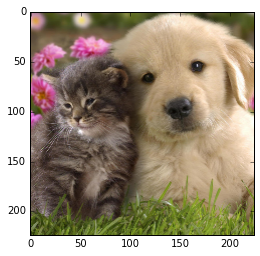

In [30]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [31]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [39]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.2)[1:-1])

orange and white kitty
camera in a bed with a hat on it
comforter and cat at a small table
demon cat on a table look piece of birthday cake
tool looking out of a piece of bread
#UNK# with both hands in black and white shirt and wearing beads and scarves in the background
slim cat sitting on top of a bed
bare #UNK# next to each other near the face
pet a cat with a lot of stuffed animals
stuffed toy looking laying next to each other through the animal


# best: demon cat on a table look piece of birthday cake


In [43]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

cat and a stuffed animal in the grass
a stuffed animal on a wooden floor with a red frisbee
sign on a couch with a stuffed animal
a red tie
stuffed toy with a teddy bear and a stuffed animal
slim a stuffed animal that is shown
bed with a stuffed animal and a teddy bear
#UNK# with a stuffed animal in the mirror
a teddy bear that is laying on a red couch
#UNK# knit eyes and a window


# cat and a stuffed animal in the grass - очень даже похоже!

# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 